In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import yaml
from torch import nn
import timm
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

"""
    This script is used to generate the Grad-CAMPlusPlus visualization for the images which our model errors on the train dataset .
"""


class BaseModelEffNet(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg['model'], pretrained=self.cfg['pretrained'],
                                       in_chans=self.cfg['in_channels'],
                                       num_classes=100)
        n_features = self.model.fc.in_features
        self.model.head = nn.Linear(n_features, cfg['target_size'])

    def forward(self, x):
        output = self.model(x)

        return output


cfg = yaml.safe_load(open('/home/mithil/PycharmProjects/Cultivar_FGVC9/cfg/tf_efficientnet_b4_ns_inference.yaml', "r"))


def return_filpath(name, folder):
    """
    This function is used to return the file path of the image.
    :param name:
    :param folder:
    :return:
    """
    path = os.path.join(folder, f'{name}')
    return path


def search_layer(module, layer_type, reverse=True):
    """
    This function is used to search the layer in the model.
    :param module:
    :param layer_type:
    :param reverse:
    :return:
    """
    if isinstance(module, layer_type):
        return module

    if not hasattr(module, 'children'):
        return None

    children = list(module.children())
    if reverse:
        children = reversed(children)
    # search for the first occurence recursively
    for child in children:
        res = search_layer(child, layer_type)
        if res:
            return res
    return None


def get_test_transforms(DIM=512):
    return A.Compose(
        [
            A.Resize(DIM, DIM),
            A.Normalize(
                mean=[0.3511794, 0.37462908, 0.2873578],
                std=[0.20823358, 0.2117826, 0.16226698],
            ),
            ToTensorV2(p=1.0)
        ]
    )

In [5]:
# TODO: add GradCam ++
import plotly.express as px

device = torch.device('cpu')
oof = pd.read_csv('/home/mithil/PycharmProjects/Cultivar_FGVC9/oof/tf_efficientnetv2_m_tta_oof.csv')
oof_probability = np.load('/home/mithil/PycharmProjects/Cultivar_FGVC9/oof/tf_efficientnetv2_m_tta_oof_probablity.npy')
oof['file_path'] = oof['image_id'].apply(
    lambda x: return_filpath(x, folder='/home/mithil/PycharmProjects/Cultivar_FGVC9/data/archive/train'))
images_path = oof['file_path'].values
ids = {}
truth_ids = []
for i, (pred, truth, pred_int) in enumerate(zip(oof['prediction'].values, oof['cultivar'].values, oof['cultivar_int'])):
    if pred == truth:
        ids.update({i: oof['file_path'].values[i]})
        truth_ids.append(truth)
print(len(ids))
model = BaseModelEffNet(cfg)
model.load_state_dict(torch.load(

    '/home/mithil/PycharmProjects/Cultivar_FGVC9/models/resnet34/resnet34_fold3_epoch4_accuracy_0.7960000038146973.pth',
    map_location=device))
model.eval()
target_layer = search_layer(model, torch.nn.Conv2d)
augs = get_test_transforms(1024)
print(target_layer)

21901
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


torch.Size([1, 3, 1024, 1024])


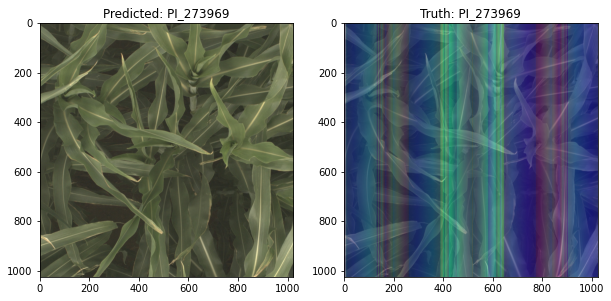

In [14]:

for key, values in ids.items():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.subplots(1, 2)
    img = cv2.imread(values)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images = augs(image=img)['image']
    images = images[None,:,:,:]
    print(images.shape)
    cam = GradCAM(model, [target_layer], use_cuda=False)
    img_1 = img.astype(np.float32) / 255.0

    cam_output = cam(input_tensor=images, targets=None)

    im = show_cam_on_image(img_1, cam_output, use_rgb=True)

    ax[0].imshow(img)
    ax[0].set_title(f'Predicted: {oof["prediction"].values[key]}')
    ax[1].imshow(im)
    ax[1].set_title(f'Truth: {oof["cultivar"].values[key]}')
    plt.show()
    break


In [7]:
    """from matplotlib import cm

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(oof_probability)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 8))
num_categories = 100
for lab in range(num_categories):
    indices = oof['cultivar_int'].values == lab
    ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], c=np.array(cmap(lab)).reshape(1, 4), label=lab, alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()"""

"from matplotlib import cm\n\ntsne = TSNE(2, verbose=1)\ntsne_proj = tsne.fit_transform(oof_probability)\n# Plot those points as a scatter plot and label them based on the pred labels\ncmap = cm.get_cmap('tab20')\nfig, ax = plt.subplots(figsize=(8, 8))\nnum_categories = 100\nfor lab in range(num_categories):\nindices = oof['cultivar_int'].values == lab\nax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], c=np.array(cmap(lab)).reshape(1, 4), label=lab, alpha=0.5)\nax.legend(fontsize='large', markerscale=2)\nplt.show()"